# HDBSCAN Clustering for RBD sequences
---
### DEMO
https://scikit-learn.org/stable/auto_examples/cluster/plot_hdbscan.html#sphx-glr-auto-examples-cluster-plot-hdbscan-py
--- 
### Parquet Making
We will be making a parquet for the entire file. Then we can sample from it randomly.

In [57]:
import os
import tqdm
import torch
import pickle
import numpy as np
import pandas as pd
from torch import nn
from torch.utils.data import Dataset, DataLoader
from transformers import AutoTokenizer, EsmModel

import hdbscan
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from umap import UMAP
from sklearn.manifold import TSNE
from sklearn.metrics import silhouette_score, adjusted_rand_score

Merging the metadata with the sequence data.

In [58]:
data_dir = "../../data/rbd"

csv_file = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.csv")
df = pd.read_csv(csv_file, header=0, low_memory=False)
df

,seq_id,sequence,variant
0,EPI_ISL_5120698,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
1,EPI_ISL_5123727,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
2,EPI_ISL_14904955,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
3,EPI_ISL_5119677,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta
4,EPI_ISL_14904971,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
...,...,...,...
347427,EPI_ISL_14903692,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
347428,EPI_ISL_14902388,RVQPTESIVRFPNITNLCPFDEVFNATTFASVYAWNRKRISNCVAD...,Omicron
347429,EPI_ISL_14905423,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron
347430,EPI_ISL_5123715,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta


In [3]:
meta_data = os.path.join(data_dir, f"original/spikeprot0528.clean.uniq.noX.RBD.metadata.tsv")
metadata_df = pd.read_csv(meta_data, sep='\t', header=0, low_memory=False)
metadata_df = metadata_df.rename(columns={'Accession ID': 'seq_id'})
metadata_df = metadata_df[['seq_id', 'Pango lineage', 'Location', 'Collection date', 'AA Substitutions']]

merged_df = pd.merge(df, metadata_df, on='seq_id', how='left')

print(merged_df['variant'].value_counts())
merged_df.head(5)

variant
Omicron    160016
Delta      109448
UNKNOWN     40917
Alpha       22075
Gamma        5978
Iota         2044
Epsilon      1915
Beta         1342
Lambda        985
Mu            939
Eta           611
Zeta          578
Kappa         505
GH/490R        57
Theta          22
Name: count, dtype: int64


,seq_id,sequence,variant,Pango lineage,Location,Collection date,AA Substitutions
0,EPI_ISL_5120698,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta,B.1.617.2,Europe / Germany / Berlin,2021-10-06,"(NSP1_V54del,NSP3_A1321del,N_G215C,NSP3_S1314d..."
1,EPI_ISL_5123727,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta,AY.4,Europe / United Kingdom / England,2021-10-08,"(N_G215C,NSP3_A1711V,Spike_T95I,N_D63G,N_R203M..."
2,EPI_ISL_14904955,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron,BA.5.5,North America / USA / Maryland,2022-08-22,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."
3,EPI_ISL_5119677,RVQPTESIVRFPNITNLCPFGEVFNATRFASVYAWNRKRISNCVAD...,Delta,AY.126,Europe / Germany / Lower Saxony,2021-09-30,"(N_G215C,Spike_T95I,N_D63G,N_R203M,NSP12_G671S..."
4,EPI_ISL_14904971,RVQPTESIVRFPNITNLCPFDEVFNATRFASVYAWNRKRISNCVAD...,Omicron,BA.5.6,North America / USA / California,2022-08-22,"(NSP5_P132H,Spike_H69del,NSP3_G489S,Spike_L24d..."


In [4]:
ado_df = merged_df[merged_df['variant'].isin(["Alpha", "Delta", "Omicron"])]
save_as = os.path.join(data_dir, f"spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv")
ado_df.to_csv(save_as, index=False)
ado_df['variant'].value_counts()

variant
Omicron    160016
Delta      109448
Alpha       22075
Name: count, dtype: int64

Making the parquet.

In [7]:
# Parquet Making
class RBDDataset(Dataset):
    """ BetaCorona virus sequence dataset, embedded with ESM model. """

    def __init__(self, csv_file:str):
        self.df = pd.read_csv(csv_file, header=0, na_filter=False)
        self.max_sequence_length = self.df['sequence'].apply(len).max()

    def __len__(self) -> int:
        return len(self.df)

    def __getitem__(self, idx):
        columns = (
            self.df.iloc[idx]["seq_id"],
            self.df.iloc[idx]["variant"],
            self.df.iloc[idx]["Pango lineage"],
            self.df.iloc[idx]["Location"],
            self.df.iloc[idx]["Collection date"],
            self.df.iloc[idx]["AA Substitutions"],
            self.df.iloc[idx]["sequence"],
        )
        return columns

class ESM(nn.Module):
    def __init__(self, esm):
        super().__init__()
        self.esm = esm

    def forward(self, tokenized_seqs):
        with torch.set_grad_enabled(self.training):  # Enable gradients, managed by model.eval() or model.train() in epoch_iteration
            last_hidden_states = self.esm(**tokenized_seqs).last_hidden_state # shape: (batch_size, sequence_length, embedding_dim)
            cls_embedding = last_hidden_states[:, 0, :]  # CLS token embedding (sequence-level representations)
        return cls_embedding

def run_model(model, tokenizer, dataloader, device, csv_file):   
    """ Call the ESM model to generate hidden states and store batch data in DataFrame directly. """
    
    model = model.to(device)
    model.eval()

    # Set the tqdm progress bar
    data_iter = tqdm.tqdm(enumerate(dataloader),
                          total = len(dataloader),
                          bar_format='{l_bar}{r_bar}')

    batch_dataframes = []

    for _, batch_data in data_iter:
        seq_ids, variants, pango_lineages, locations, collection_dates, aa_subs, sequences = batch_data 

        # Add 2 to max_length to account for additional tokens added to beginning and end by ESM
        max_length = dataloader.dataset.max_sequence_length + 2
        tokenized_seqs = tokenizer(sequences, return_tensors='pt', padding='max_length', max_length=max_length).to(device) 
        
        with torch.no_grad():
            embeddings = model(tokenized_seqs) # shape: [batch_size, sequence_len, embedding_dim]

        # Create a DataFrame for the batch
        batch_df = pd.DataFrame({
            "seq_id": seq_ids,
            "variant": variants,
            "Pango lineage": pango_lineages,
            "Location": locations,
            "Collection date": collection_dates,
            "AA Substitutions": aa_subs,
            "embedding": [embedding.cpu().numpy() for embedding in embeddings]  # Convert tensor to numpy array for each embedding
        })

        batch_dataframes.append(batch_df)

    # Concatenate all batch DataFrames into one
    result_df = pd.concat(batch_dataframes, ignore_index=True)
    
    # Save data to a Parquet file
    save_as = csv_file.replace(".csv", "_CLS-embedded.parquet")
    save_as = save_as.replace("/data/rbd", "/data/rbd/parquets/embeddings")
    result_df.to_parquet(save_as, index=False)
    print(f"Data saved to {save_as}")

# Set device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
batch_size = 64

# Data file
data_dir = "../../data/rbd"
csv_file = os.path.join(data_dir, "spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO.csv")
dataset = RBDDataset(csv_file)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# ESM input
esm_version = "facebook/esm2_t6_8M_UR50D"
esm = EsmModel.from_pretrained(esm_version, cache_dir='../model_downloads').to(device)
tokenizer = AutoTokenizer.from_pretrained(esm_version, cache_dir='../model_downloads')

model = ESM(esm)
run_model(model, tokenizer, dataloader, device, csv_file)

Some weights of EsmModel were not initialized from the model checkpoint at facebook/esm2_t6_8M_UR50D and are newly initialized: ['esm.pooler.dense.weight', 'esm.pooler.dense.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
100%|| 4556/4556 [05:32<00:00, 13.69it/s]


Data saved to ../../data/rbd/parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet


---

### Clustering - tSNE, then HDBSCAN
Sampling from the embeddings.

In [8]:
parquet_file = os.path.join(data_dir, "parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Random sampling
min_sample_size = embedded_ado_df['variant'].value_counts().min()
sample_sizes = {"Alpha": min_sample_size,
                "Delta": min_sample_size,
                "Omicron": min_sample_size}

rnd_seed = 0
sampled_dfs = [embedded_ado_df[embedded_ado_df['variant'] == variant].sample(n=sample_sizes[variant], random_state=rnd_seed)
                           for variant in sample_sizes.keys()]
    
sampled_ado_df = pd.concat(sampled_dfs)
print(sampled_ado_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed{rnd_seed}.parquet")
sampled_ado_df.to_parquet(save_as, index=False)

variant
Alpha      22075
Delta      22075
Omicron    22075
Name: count, dtype: int64


Apply tSNE to the embeddings, then save the tSNE embeddings. I used 1% of the data to set the perplexity for this large dataset (>10,000): https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6882829/.

In [5]:
# Load in the data
parquet_file = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_ado_df["embedding"])
info_df = embedded_ado_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix, took ~ 13 min
perplexity = round(len(info_df) * 0.01) 
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

# Save the embedding
embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.tsne-perp{perplexity}.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

Load in the tSNE embeddings.

In [75]:
# Load the embedding
perplexity = 662
parquet_file = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.tsne-perp{perplexity}.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced = embedded_ado_df[['DIM_1', 'DIM_2']].values
info_df = embedded_ado_df.drop(columns=['DIM_1', 'DIM_2'])

Find highest or a sufficiently highest Silhouette Coefficient, Adjusted Rand Index.

In [6]:
for i in [100, 1000, 1500, 2000]:
    for j in [1000, 10000, 15000, 20000, 21000, 22000]:
        # Cluster
        hdb_labels = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
        ari = adjusted_rand_score(info_df["variant"], hdb_labels)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 100, min_cluster_size 1000: (Silhouette Coefficient 0.63, Adjusted Rand Index 0.48)
min_sample 100, min_cluster_size 10000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 15000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 20000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 21000: (Silhouette Coefficient 0.65, Adjusted Rand Index 0.97)
min_sample 100, min_cluster_size 22000: (Silhouette Coefficient 0.51, Adjusted Rand Index 0.55)
min_sample 1000, min_cluster_size 1000: (Silhouette Coefficient 0.59, Adjusted Rand Index 0.58)
min_sample 1000, min_cluster_size 10000: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.97)
min_sample 1000, min_cluster_size 15000: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.97)
min_sample 1000, min_cluster_size 20000: (Silhouette Coefficient 0.67, Adjusted Rand Index 0.97)
min_sample 1000, min_cluster_size 2100

Plotting the tSNE embeddings after applying HDBSCAN.

In [84]:
def plot_hdbscan_comparison(save_as, info_df, embedding_matrix, hdb_labels, data_column, colormap):   
    # Ground truth color mapping
    unique_data_values = info_df[data_column].unique()
    ground_truth_colors = sns.color_palette(colormap, n_colors=len(unique_data_values))
    ground_truth_color_dict = dict(zip(unique_data_values, ground_truth_colors))

    # HDBSCAN cluster color mapping
    unique_clusters = np.unique(hdb_labels)
    if (len(unique_clusters)-1) > 10:
        cluster_colors = sns.color_palette("colorblind", 10) + sns.color_palette(["#999933", "#882255", "#661100", "#6699CC", "#332288"])
    else:
        cluster_colors = sns.color_palette(colormap, n_colors=len(unique_clusters)-1)  # -1 to exclude outliers
    cluster_color_dict = {label: color for label, color in zip(unique_clusters[unique_clusters != -1], cluster_colors)}
    cluster_color_dict[-1] = 'black'  # Outliers are gray

    n_predicted_clusters = len(unique_clusters) - (1 if -1 in unique_clusters else 0)
    n_true_clusters = len(unique_data_values)

    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    fontsize = 20

    # Left subplot: HDBSCAN clusters
    ax1 = axes[0]
    ax1.set_title(f'Predicted: {n_predicted_clusters} clusters', fontsize=fontsize)
    for label in unique_clusters:
        mask = hdb_labels == label
        if label == -1:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c='black', label='Outliers', marker='x', s=35)
        else:
            ax1.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                        c=[cluster_color_dict[label]], label=f'Cluster {label}',
                        s=20, alpha=0.75)
    ax1.legend(loc='upper left', fontsize=fontsize-6, markerscale=2)

    # Right subplot: Ground truth 
    ax2 = axes[1]
    ax2.set_title(f'Ground Truth: {n_true_clusters} clusters', fontsize=fontsize)
    for value in unique_data_values:
        mask = info_df[data_column] == value
        ax2.scatter(embedding_matrix[mask, 0], embedding_matrix[mask, 1],
                    c=[ground_truth_color_dict[value]], label=value,
                    s=20, alpha=0.75)

    ax2.legend(loc='upper left', fontsize=fontsize-6, markerscale=2)

    for ax in axes:
        ax.set_xlabel('Component 1', fontsize=fontsize)
        ax.set_ylabel('Component 2', fontsize=fontsize)
        ax.tick_params(axis='both', which='major', labelsize=fontsize)

    plt.tight_layout()
    plt.savefig(f"{save_as}.pdf", format="pdf")
    plt.savefig(f"{save_as}.png", format="png")
    plt.show()

def plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, data_column):
    # Create the truth table
    truth_table_percent = pd.crosstab(info_df[data_column], hdb_labels, 
                                    rownames=['Ground Truth'], 
                                    colnames=['Predicted Clusters'],
                                    normalize='index')  # Normalize along the index (rows)
    truth_table_percent = (truth_table_percent * 100)

    # Plot heatmap
    plt.figure(figsize=(16, 9))
    fontsize = 20
    heatmap = sns.heatmap(truth_table_percent, annot=True, cmap='coolwarm', fmt='.2f', annot_kws={"size": fontsize})
    cbar = heatmap.collections[0].colorbar
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.set_label('Percentage (%)', fontsize=fontsize) 
    plt.title('Ground Truth vs Predicted Clusters', fontsize=fontsize)
    plt.xlabel('Predicted Clusters', fontsize=fontsize)
    plt.xticks(fontsize=fontsize)
    plt.ylabel('Ground Truth', fontsize=fontsize)
    plt.yticks(fontsize=fontsize)
    plt.tight_layout()
    plt.savefig(save_as + ".truthtable.pdf", format="pdf")
    plt.savefig(save_as + ".truthtable.png", format="png")
    plt.show()

In [85]:
min_samples=1500
min_cluster_size=21000

# Cluster
hdb_labels = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size,
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced, hdb_labels)
ari = adjusted_rand_score(info_df["variant"], hdb_labels)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.ADO.seed0.tsne-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_comparison(save_as, info_df, embedding_matrix_reduced, hdb_labels, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df, hdb_labels, "variant")

truth_table = pd.crosstab(info_df["variant"], hdb_labels, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df['Cluster'] = hdb_labels
result = cluster_pango_lineage(info_df, 5)
# result.to_csv('./data/RBD_cluster_lineages-old_ESM-BLSTM.csv', index=False)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df, "colorblind")

KeyboardInterrupt: 

Side note, I have tried setting min_cluster_size close to the value of the number of samples per variant (trying to capture this clustering) and this achieves high ARI score. This makes some sense since min_cluster_size is the minimum number of points to form a cluster; setting it close to the sample per variant already matches the natural grouping structure of the data. So I am going to adjust the min_samples to see if we can't get an even better SC/ARI.

SC shows how:
- Clusters are well-separated (points in different clusters are far apart).
- Points within the same cluster are tightly grouped (points within a cluster are close together).

In a sense, a higher min_samples should mean tighter clusters, higher SC. So need the best balance between SC and ARI.

### Omicron only
Extract the omicron values only

In [63]:
# Load the embedding
perplexity = 662
parquet_file = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.seed0.tsne-perp{perplexity}.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedded_ado_o_df = embedded_ado_df[embedded_ado_df['variant'].isin(["Omicron"])]
print(embedded_ado_o_df['variant'].value_counts())

embedding_matrix_reduced_ado_o = embedded_ado_o_df[['DIM_1', 'DIM_2']].values
info_df_ado_o = embedded_ado_o_df.drop(columns=['DIM_1', 'DIM_2'])

variant
Omicron    22075
Name: count, dtype: int64


In [95]:
for i in [5, 10, 15, 20, 25, 50, 100, 250, 300, 350, 400, 450, 500, 1000]:
    for j in [500, 1000, 1250, 1500, 2000, 2500, 3000]:
        # Cluster
        hdb_labels_ado_o = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j, 
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced_ado_o).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced_ado_o, hdb_labels_ado_o)
        ari = adjusted_rand_score(info_df_ado_o["variant"], hdb_labels_ado_o)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 5, min_cluster_size 500: (Silhouette Coefficient 0.29, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 1000: (Silhouette Coefficient 0.33, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 1250: (Silhouette Coefficient 0.34, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 1500: (Silhouette Coefficient 0.53, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 2000: (Silhouette Coefficient 0.62, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 2500: (Silhouette Coefficient 0.62, Adjusted Rand Index 0.00)
min_sample 5, min_cluster_size 3000: (Silhouette Coefficient 0.62, Adjusted Rand Index 0.00)
min_sample 10, min_cluster_size 500: (Silhouette Coefficient 0.30, Adjusted Rand Index 0.00)
min_sample 10, min_cluster_size 1000: (Silhouette Coefficient 0.35, Adjusted Rand Index 0.00)
min_sample 10, min_cluster_size 1250: (Silhouette Coefficient 0.62, Adjusted Rand Index 0.00)
min_sample 10, min_cluster_size 1500: (Silhouette Coefficient 0.62, A

min_sample 300, min_cluster_size 500: Silhouette Coefficient: 0.60, Adjusted Rand Index: 0.00


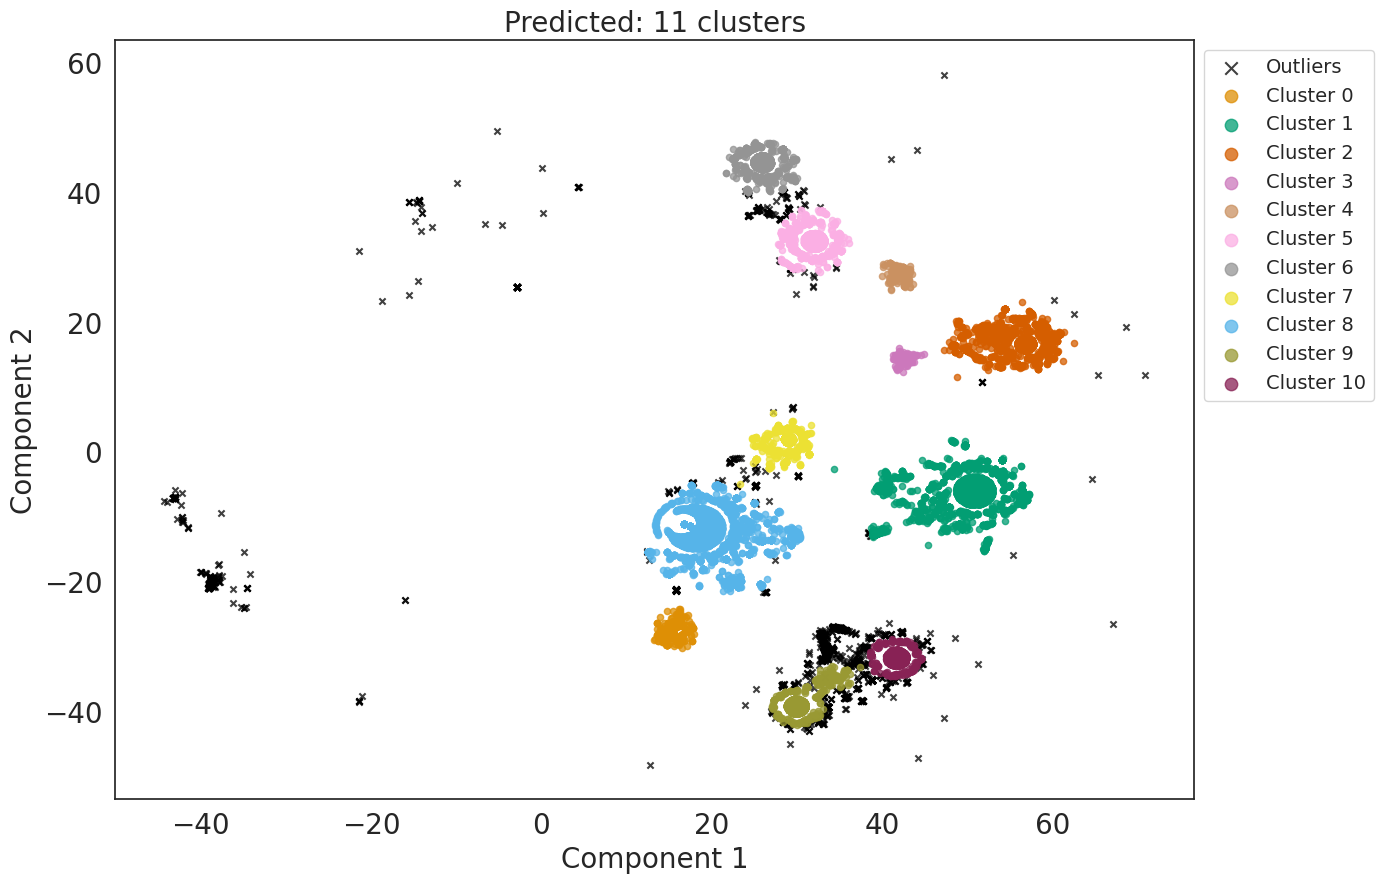

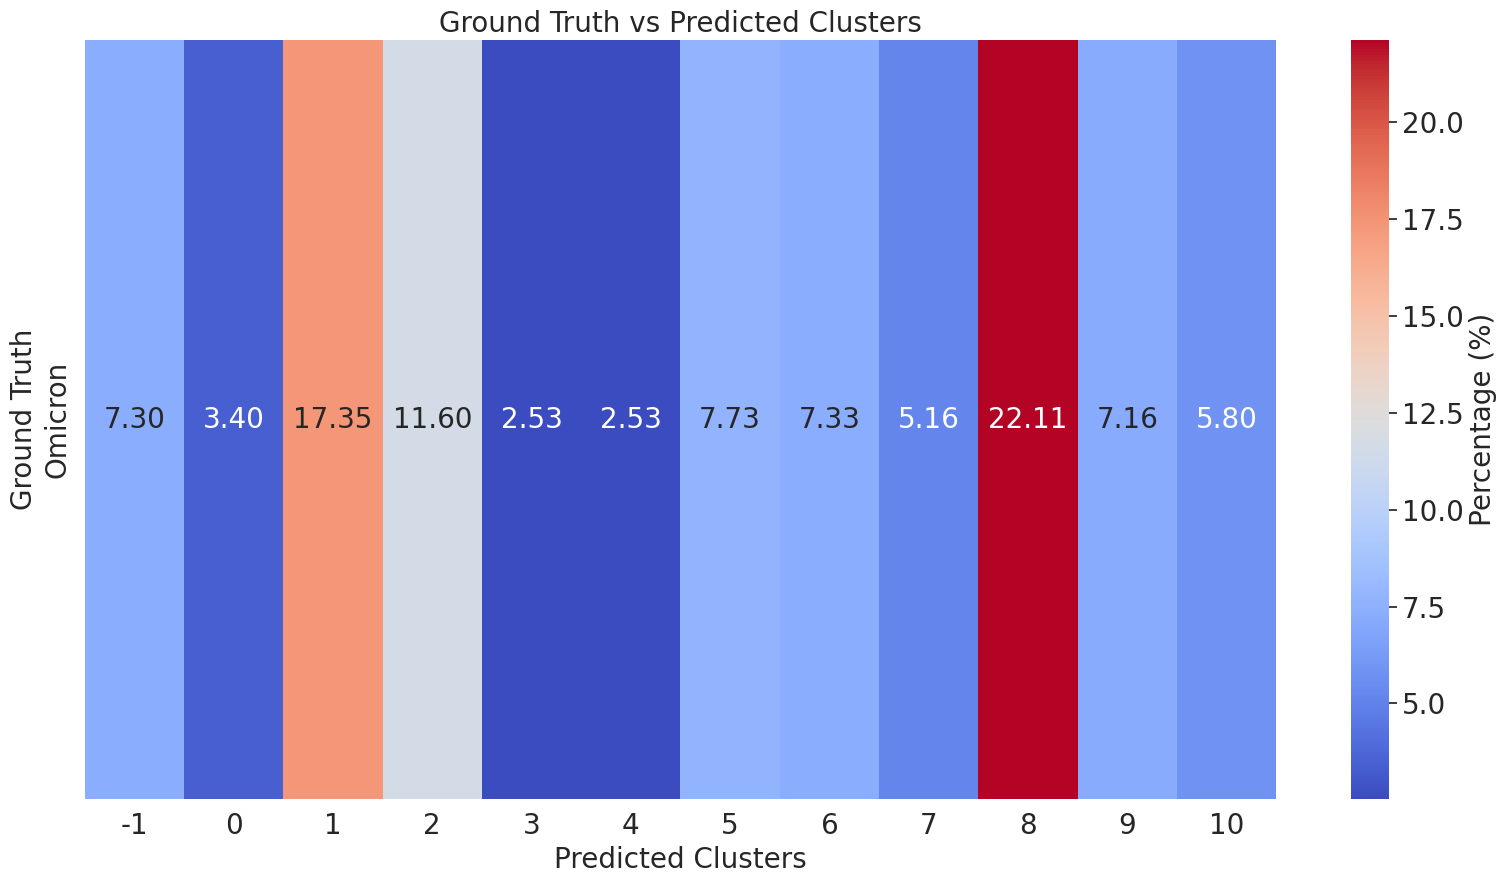

In [68]:
min_samples = 300
min_cluster_size = 500

# Cluster
hdb_labels_ado_o = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size, 
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced_ado_o).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced_ado_o, hdb_labels_ado_o)
ari = adjusted_rand_score(info_df_ado_o["variant"], hdb_labels_ado_o)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.ADO.O.seed0.tsne-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df_ado_o, embedding_matrix_reduced_ado_o, hdb_labels_ado_o, "variant", "colorblind")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df_ado_o, hdb_labels_ado_o, "variant")

Take a look at the clusters and the pango lineages in them.

   Cluster  variant Pango lineage  Cluster %  Lineage %
0       -1  Omicron       BA.1.1*  22.084367  20.215786
1       -1  Omicron          BA.1  14.081886  30.717185
2       -1  Omicron    Unassigned   7.878412  14.923619
3       -1  Omicron          BA.2   7.382134   6.134021
4       -1  Omicron       BA.5.2*   6.575682   5.042816

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        0  Omicron      BA.2.12*  81.733333  80.130719
1        0  Omicron          BA.2   3.733333   1.443299
2        0  Omicron       BA.5.2*   2.533333   0.903901
3        0  Omicron       BA.5.1*   1.600000   1.100917
4        0  Omicron    Unassigned   1.600000   1.410106

   Cluster  variant Pango lineage  Cluster %  Lineage %
0        1  Omicron          BA.2  44.763646  88.350515
1        1  Omicron       BA.2.3*   9.062418  95.068493
2        1  Omicron       BA.2.9*   7.861060  95.253165
3        1  Omicron    Unassigned   3.499608  15.746181
4        1  Omicron      BA.2.10*   3.473492  

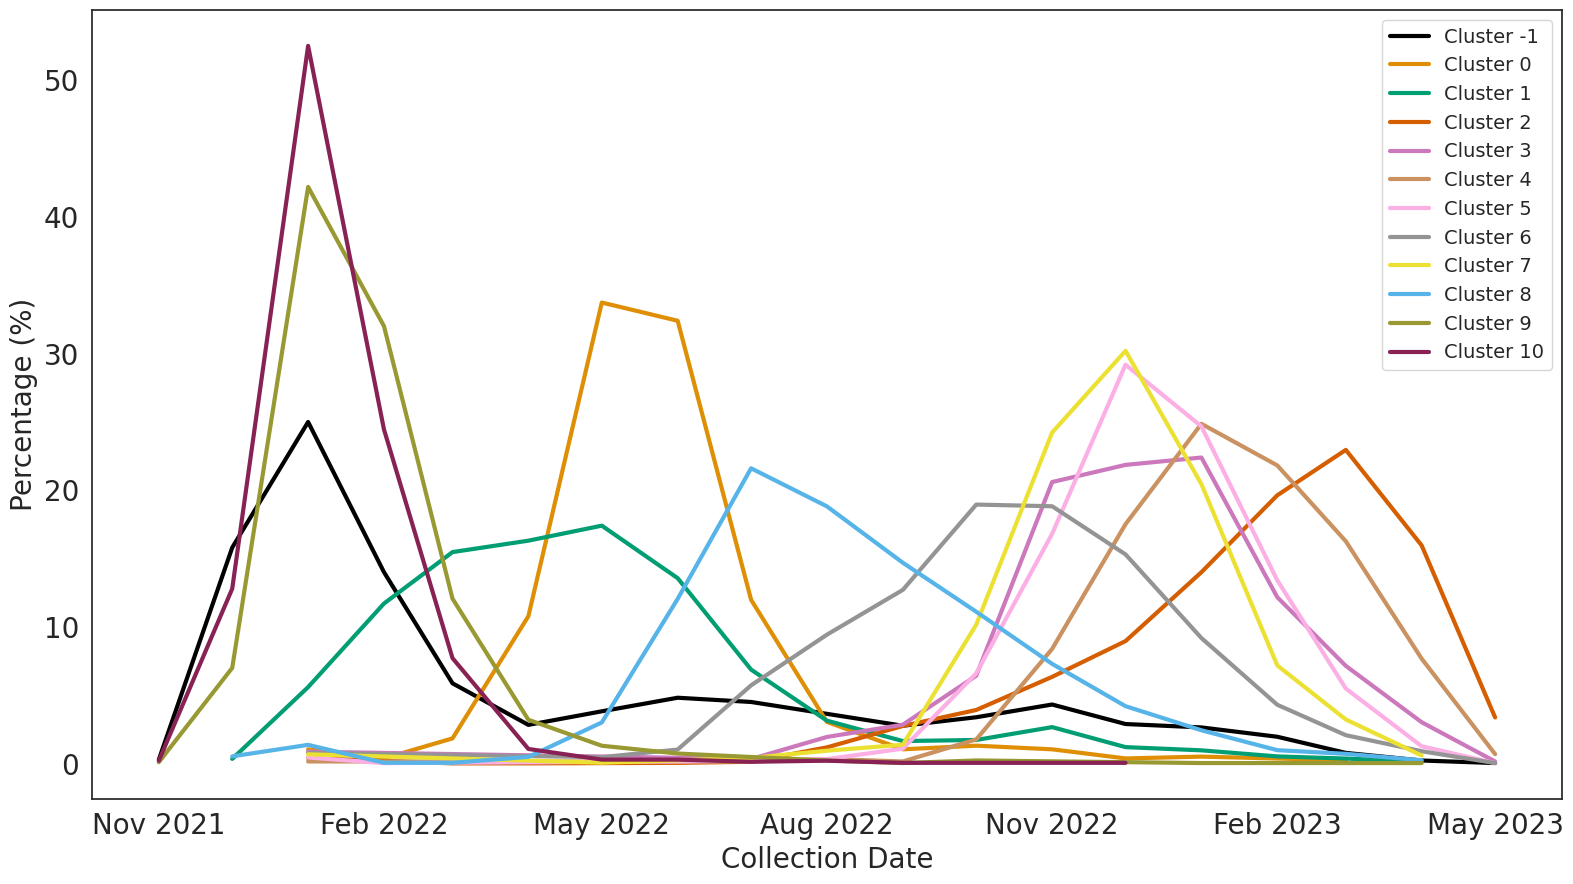

In [69]:
info_df_ado_o['Cluster'] = hdb_labels_ado_o
result = cluster_pango_lineage(info_df_ado_o, 5)
# result.to_csv('./data/RBD_cluster_lineages-old_ESM-BLSTM.csv', index=False)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df_ado_o, "colorblind")

- Cluster %: The percentage of a specific Pango lineage within a particular cluster, calculated as the number of occurrences of that lineage in the cluster divided by the total number of occurrences of all lineages in the cluster.
- Lineage %: The percentage of a specific Pango lineage's occurrences in a cluster relative to its total occurrences across the entire dataset.

Maybe better names would be Lineage Cluster %, Lineage Dataset %?

### All Omicron data (WIP)

Extract out all of the Omicron data.

In [13]:
parquet_file = os.path.join(data_dir, "parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.ADO_CLS-embedded.parquet")
embedded_ado_df = pd.read_parquet(parquet_file, engine='fastparquet')

# Extract Omicron only
embedded_o_df = embedded_ado_df[embedded_ado_df['variant'].isin(["Omicron"])]
print(embedded_o_df['variant'].value_counts())

save_as = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.parquet")
embedded_o_df.to_parquet(save_as, index=False)

variant
Omicron    160016
Name: count, dtype: int64


Apply tSNE to the embeddings.

In [14]:
# Load in the data
parquet_file = os.path.join(data_dir, f"parquets/embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.parquet")
embedded_o_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix = np.vstack(embedded_o_df["embedding"])
info_df = embedded_o_df.drop(columns=["embedding"])

# Apply tSNE to reduce the dimensionality of the embedding matrix, took ~  min
perplexity = round(len(info_df) * 0.01) 
tsne_reducer = TSNE(n_components=2, perplexity=perplexity, learning_rate='auto', random_state=0)
embedding_matrix_reduced = tsne_reducer.fit_transform(embedding_matrix)

# Save the embedding
embeddings_df = pd.DataFrame(embedding_matrix_reduced, columns=['DIM_1', 'DIM_2']).reset_index(drop=True)
tsne_df = pd.concat([info_df, embeddings_df], axis=1)
save_as = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.tsne-perp_{perplexity}.parquet")
tsne_df.to_parquet(save_as, engine='fastparquet')

Load in the tSNE embeddings.

In [70]:
# Load the embedding
perplexity = 1600
parquet_file = os.path.join(data_dir, f"parquets/tsne_embeddings/spikeprot0528.clean.uniq.noX.RBD.metadata.variants.O_CLS-embedded.tsne-perp_{perplexity}.parquet")
embedded_o_df = pd.read_parquet(parquet_file, engine='fastparquet')
embedding_matrix_reduced_o = embedded_o_df[['DIM_1', 'DIM_2']].values
info_df_o = embedded_o_df.drop(columns=['DIM_1', 'DIM_2'])

Find the highest Silhouette Coefficient and Adjusted Rand Index.

In [8]:
for i in [100, 150, 200, 225, 250, 500, 750]:
    for j in [1000, 5000, 10000, 12500, 15000, 25000, 27500]:
        # Cluster
        hdb_labels_o = hdbscan.HDBSCAN(
            min_samples=i,
            min_cluster_size=j,
            core_dist_n_jobs=-1  # Enable parallel processing
        ).fit(embedding_matrix_reduced_o).labels_

        # Evaluate clustering
        silhouette_avg = silhouette_score(embedding_matrix_reduced_o, hdb_labels_o)
        ari = adjusted_rand_score(info_df_o["variant"], hdb_labels_o)
        print(f"min_sample {i}, min_cluster_size {j}: (Silhouette Coefficient {silhouette_avg:.2f}, Adjusted Rand Index {ari:.2f})")

min_sample 100, min_cluster_size 1000: (Silhouette Coefficient 0.30, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 5000: (Silhouette Coefficient 0.40, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 10000: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 12500: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 15000: (Silhouette Coefficient 0.41, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 25000: (Silhouette Coefficient 0.48, Adjusted Rand Index 0.00)
min_sample 100, min_cluster_size 27500: (Silhouette Coefficient 0.38, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 1000: (Silhouette Coefficient 0.34, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 5000: (Silhouette Coefficient 0.45, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 10000: (Silhouette Coefficient 0.45, Adjusted Rand Index 0.00)
min_sample 150, min_cluster_size 12500: (Sil

Plotting the tSNE embeddings after applying HDBSCAN.

min_sample 250, min_cluster_size 15000: Silhouette Coefficient: 0.57, Adjusted Rand Index: 0.00


KeyError: 4

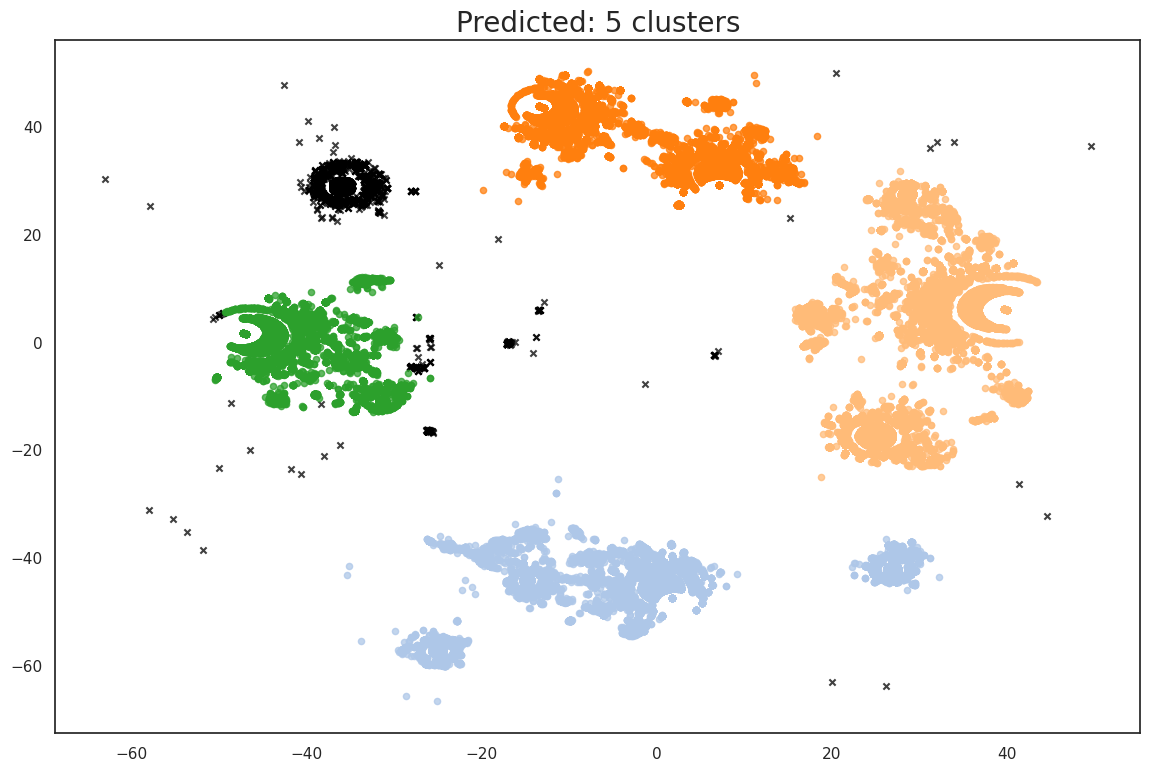

In [72]:
min_samples = 250
min_cluster_size = 15000

# Cluster
hdb_labels_o = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size, 
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced_o).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced_o, hdb_labels_o)
ari = adjusted_rand_score(info_df_o["variant"], hdb_labels_o)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.seed0.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df_o, embedding_matrix_reduced_o, hdb_labels_o, "variant", "tab20")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df_o, hdb_labels_o, "variant")

truth_table = pd.crosstab(info_df_o["variant"], hdb_labels_o, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df_o['Cluster'] = hdb_labels_o
result = cluster_pango_lineage(info_df_o, 5)
# result.to_csv('./data/RBD_cluster_lineages-old_ESM-BLSTM.csv', index=False)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df_o, "tab20")

min_sample 150, min_cluster_size 5000: Silhouette Coefficient: 0.45, Adjusted Rand Index: 0.00


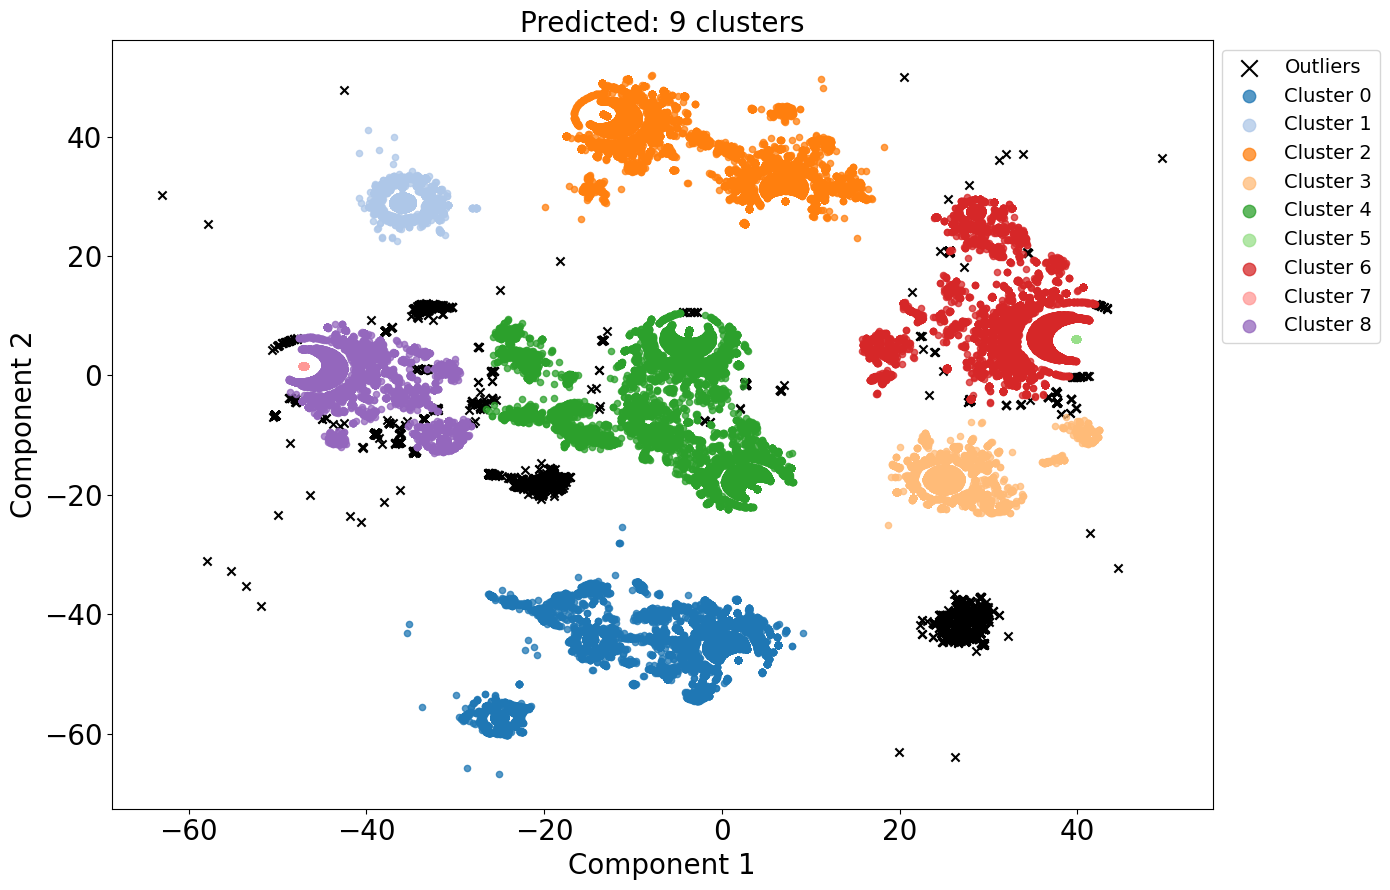

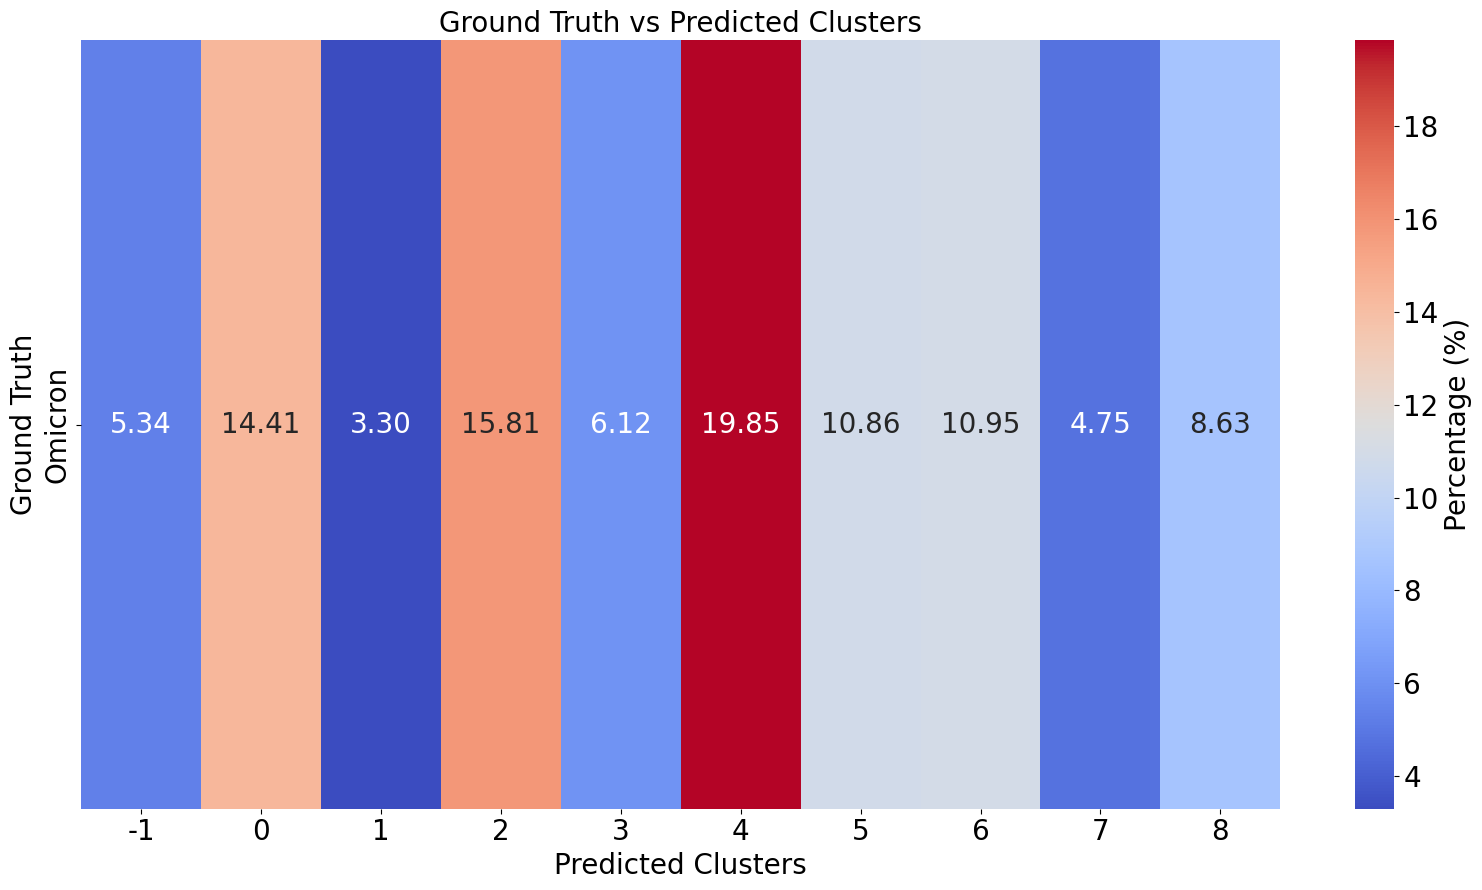

Predicted Clusters,-1,0,1,2,3,4,5,6,7,8
Ground Truth,,,,,,,,,,
Omicron,8538,23055,5281,25300,9787,31759,17375,17522,7597,13802


In [ ]:
min_samples = 150
min_cluster_size = 5000

# Cluster
hdb_labels_o = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size, 
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced_o).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced_o, hdb_labels_o)
ari = adjusted_rand_score(info_df_o["variant"], hdb_labels_o)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.seed0.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df_o, embedding_matrix_reduced_o, hdb_labels_o, "variant", "tab20")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df_o, hdb_labels_o, "variant")

truth_table = pd.crosstab(info_df_o["variant"], hdb_labels_o, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df_o['Cluster'] = hdb_labels_o
result = cluster_pango_lineage(info_df_o, 5)
# result.to_csv('./data/RBD_cluster_lineages-old_ESM-BLSTM.csv', index=False)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df_o, "tab20")

min_sample 250, min_cluster_size 5000: Silhouette Coefficient: 0.43, Adjusted Rand Index: 0.00


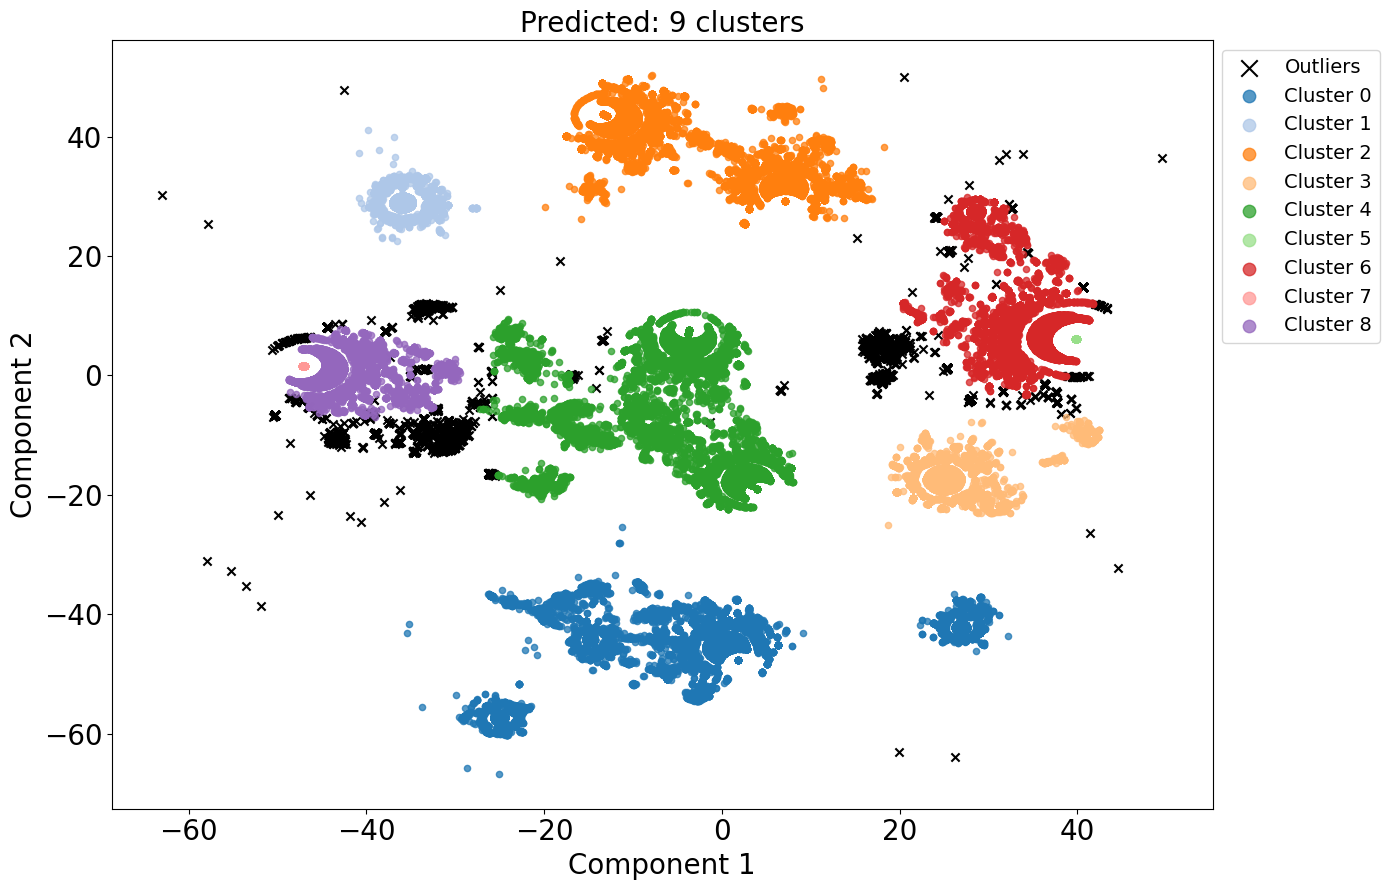

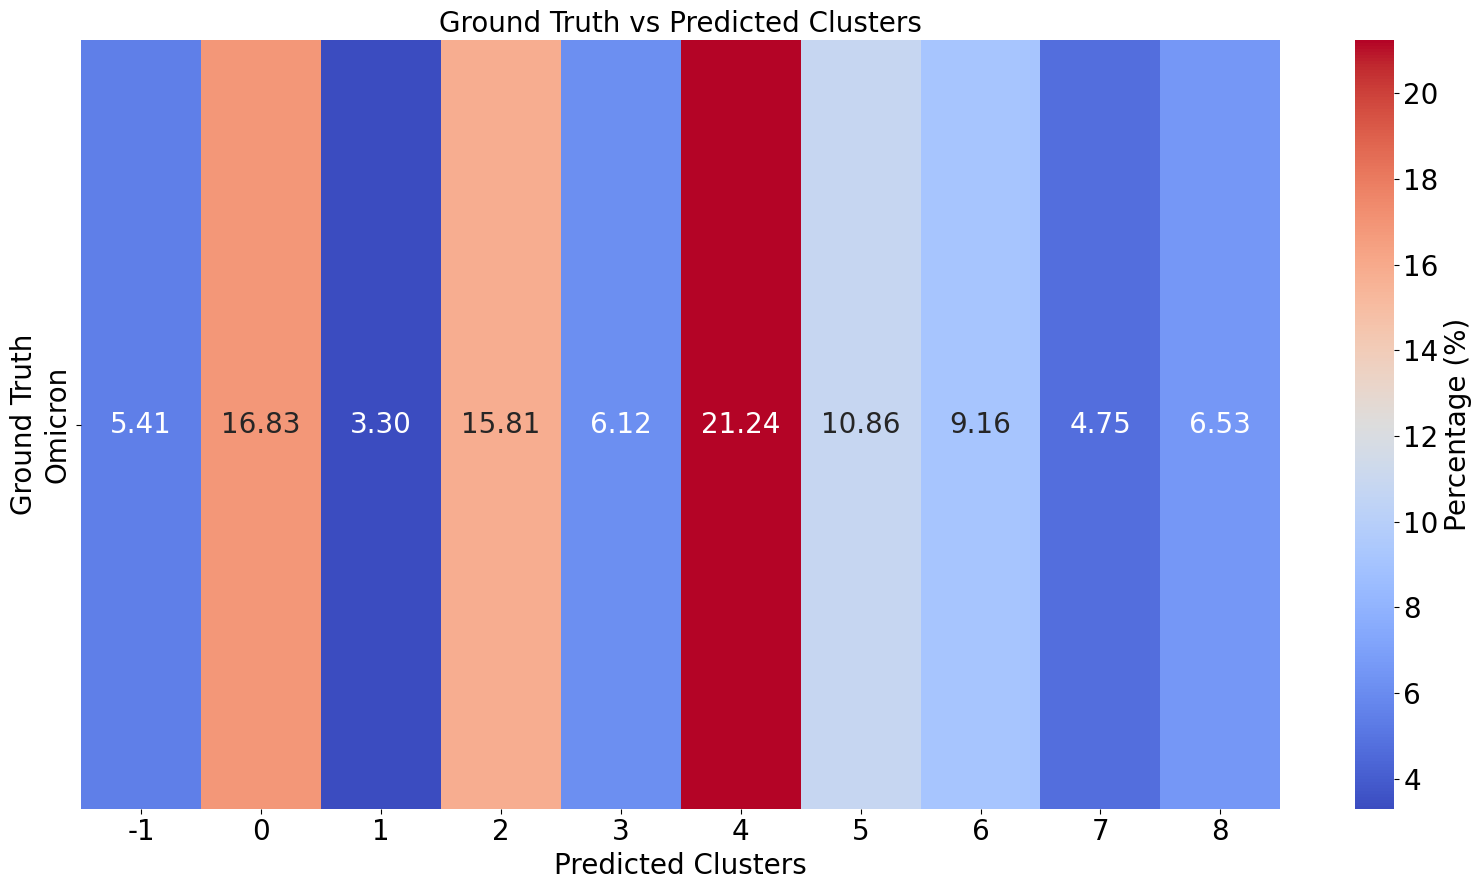

Predicted Clusters,-1,0,1,2,3,4,5,6,7,8
Ground Truth,,,,,,,,,,
Omicron,8650,26932,5281,25299,9787,33984,17375,14663,7597,10448


In [ ]:
min_samples = 250
min_cluster_size = 5000

# Cluster
hdb_labels_o = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size, 
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced_o).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced_o, hdb_labels_o)
ari = adjusted_rand_score(info_df_o["variant"], hdb_labels_o)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.seed0.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df_o, embedding_matrix_reduced_o, hdb_labels_o, "variant", "tab20")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df_o, hdb_labels_o, "variant")

truth_table = pd.crosstab(info_df_o["variant"], hdb_labels_o, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df_o['Cluster'] = hdb_labels_o
result = cluster_pango_lineage(info_df_o, 5)
# result.to_csv('./data/RBD_cluster_lineages-old_ESM-BLSTM.csv', index=False)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df_o, "tab20")

min_sample 200, min_cluster_size 5000: Silhouette Coefficient: 0.42, Adjusted Rand Index: 0.00


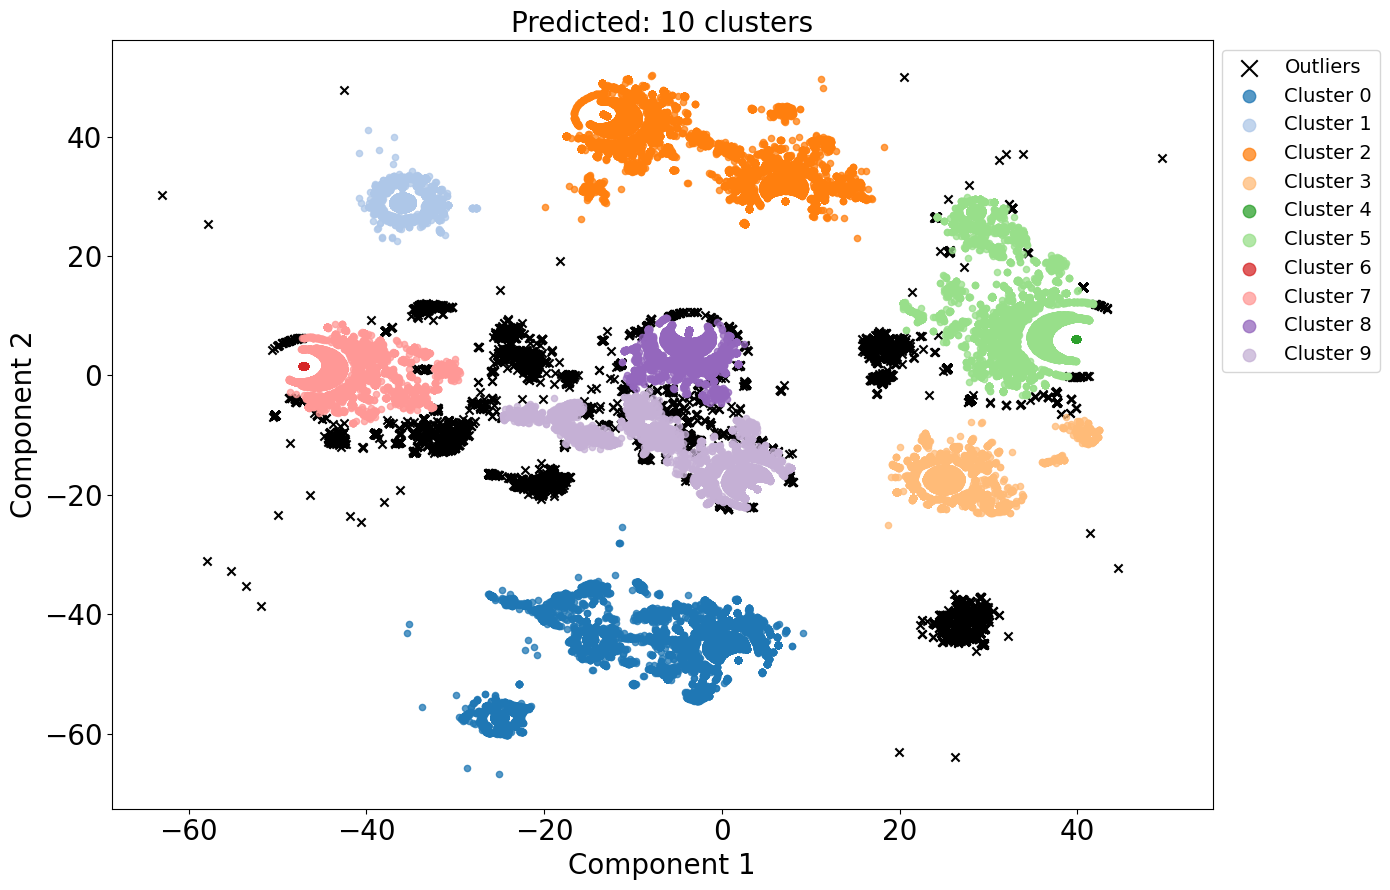

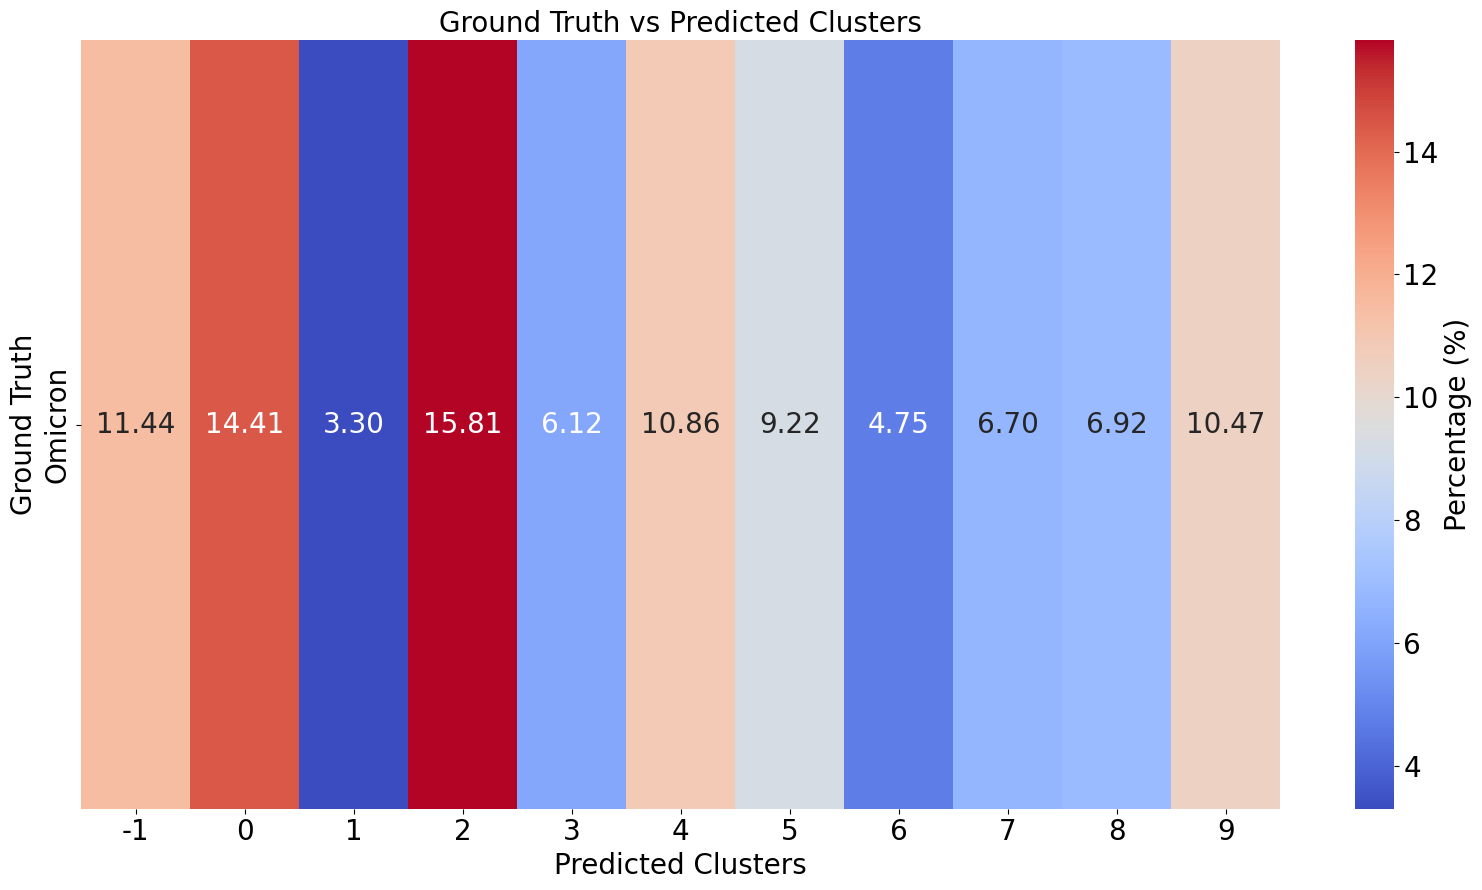

Predicted Clusters,-1,0,1,2,3,4,5,6,7,8,9
Ground Truth,,,,,,,,,,,
Omicron,18312,23055,5281,25300,9787,17375,14758,7597,10728,11066,16757


In [ ]:
min_samples = 200
min_cluster_size = 5000

# Cluster
hdb_labels_o = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size, 
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced_o).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced_o, hdb_labels_o)
ari = adjusted_rand_score(info_df_o["variant"], hdb_labels_o)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.seed0.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df_o, embedding_matrix_reduced_o, hdb_labels_o, "variant", "tab20")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df_o, hdb_labels_o, "variant")

truth_table = pd.crosstab(info_df_o["variant"], hdb_labels_o, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df_o['Cluster'] = hdb_labels_o
result = cluster_pango_lineage(info_df_o, 5)
# result.to_csv('./data/RBD_cluster_lineages-old_ESM-BLSTM.csv', index=False)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df_o, "tab20")

min_sample 200, min_cluster_size 4000: Silhouette Coefficient: 0.44, Adjusted Rand Index: 0.00


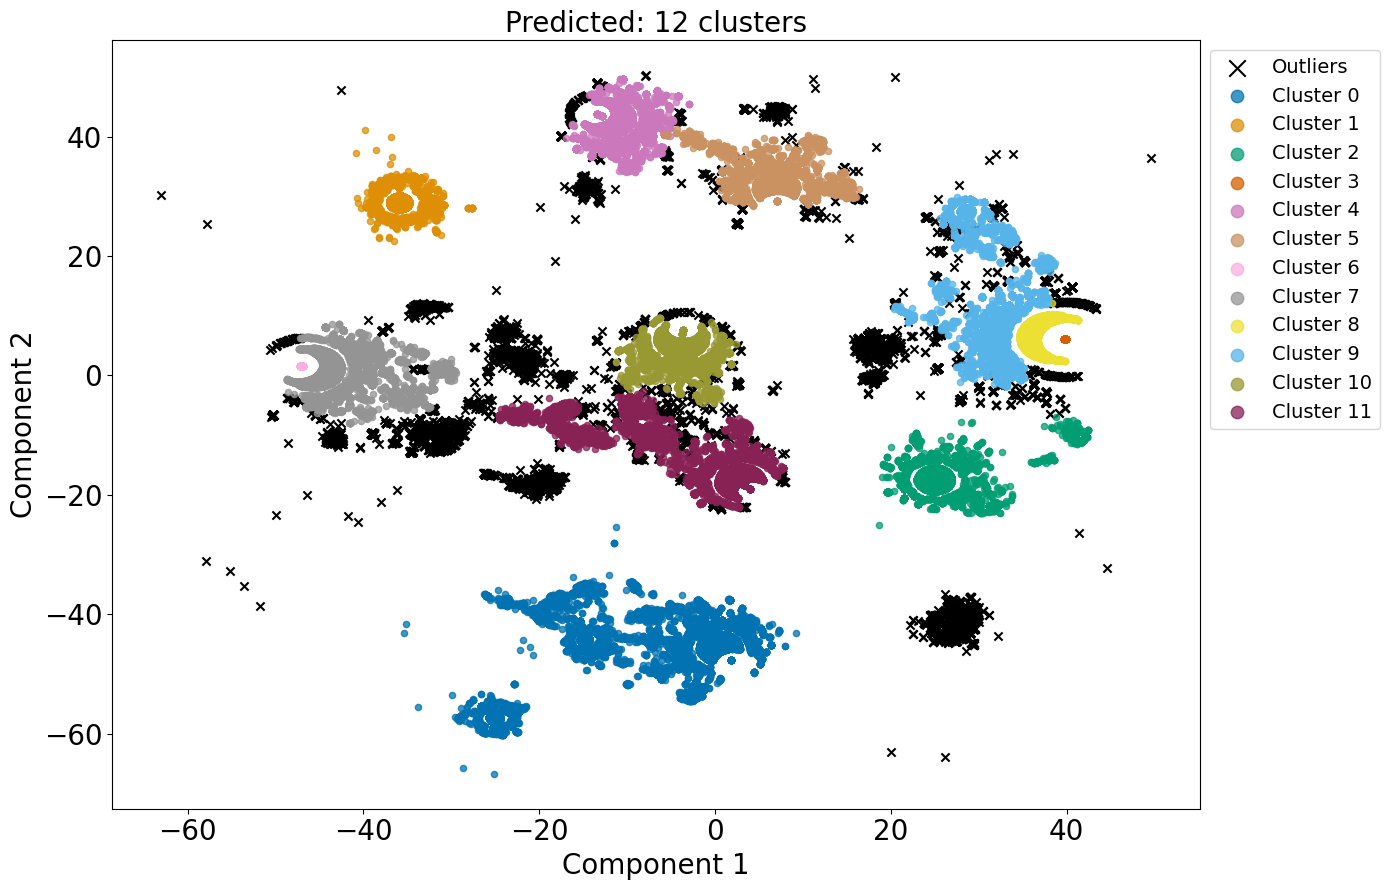

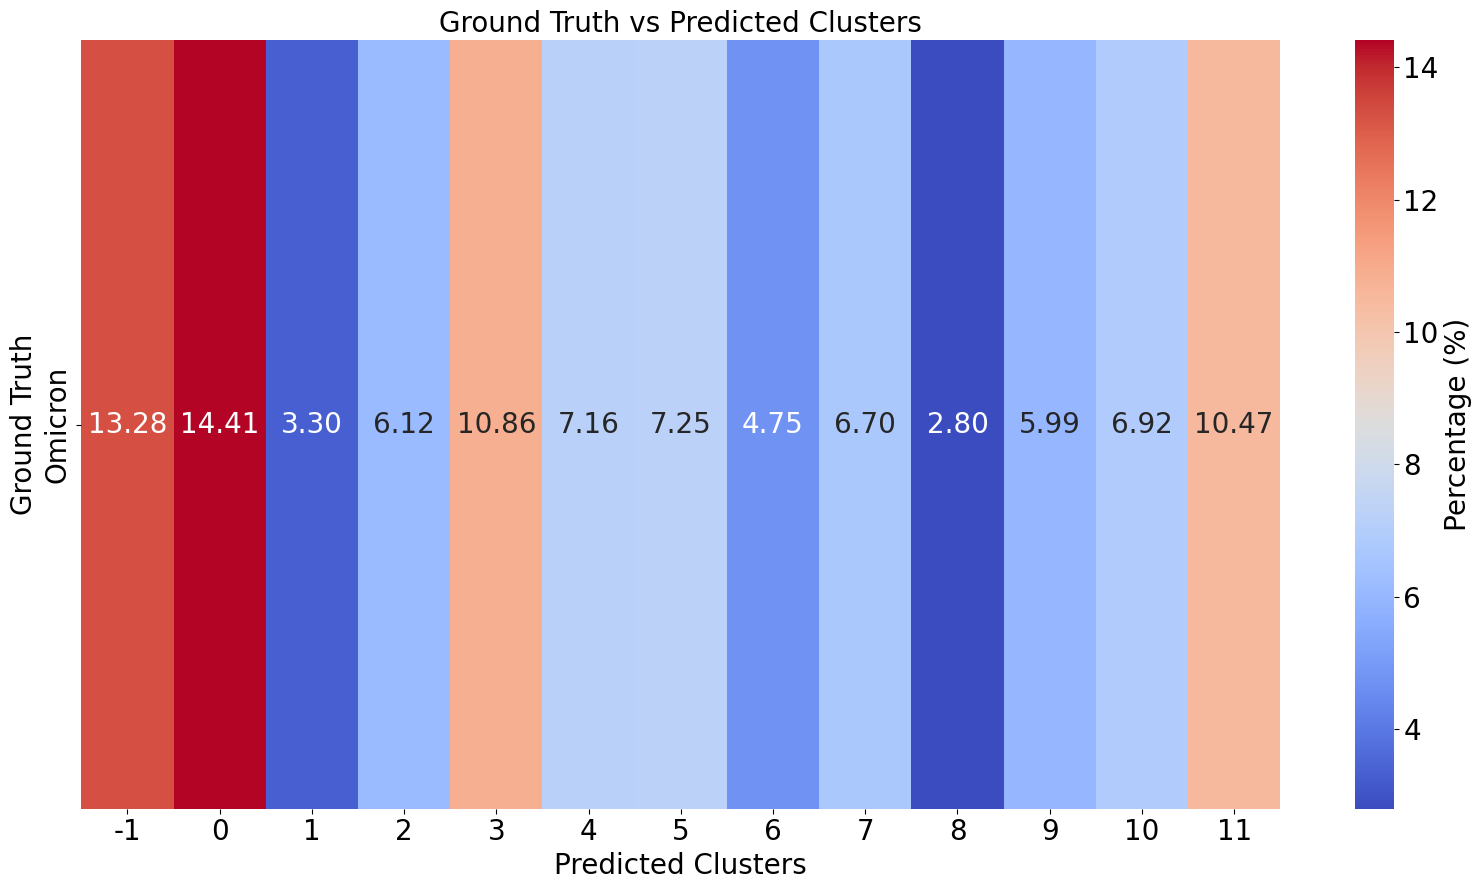

Predicted Clusters,-1,0,1,2,3,4,5,6,7,8,9,10,11
Ground Truth,,,,,,,,,,,,,
Omicron,21253,23055,5281,9787,17375,11462,11596,7597,10728,4474,9585,11066,16757


In [ ]:
min_samples = 200
min_cluster_size = 4000

# Cluster
hdb_labels_o = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size, 
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced_o).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced_o, hdb_labels_o)
ari = adjusted_rand_score(info_df_o["variant"], hdb_labels_o)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.seed0.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df_o, embedding_matrix_reduced_o, hdb_labels_o, "variant", "tab20")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df_o, hdb_labels_o, "variant")

truth_table = pd.crosstab(info_df_o["variant"], hdb_labels_o, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df_o['Cluster'] = hdb_labels_o
result = cluster_pango_lineage(info_df_o, 5)
# result.to_csv('./data/RBD_cluster_lineages-old_ESM-BLSTM.csv', index=False)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df_o, "tab20")

min_sample 250, min_cluster_size 4000: Silhouette Coefficient: 0.42, Adjusted Rand Index: 0.00


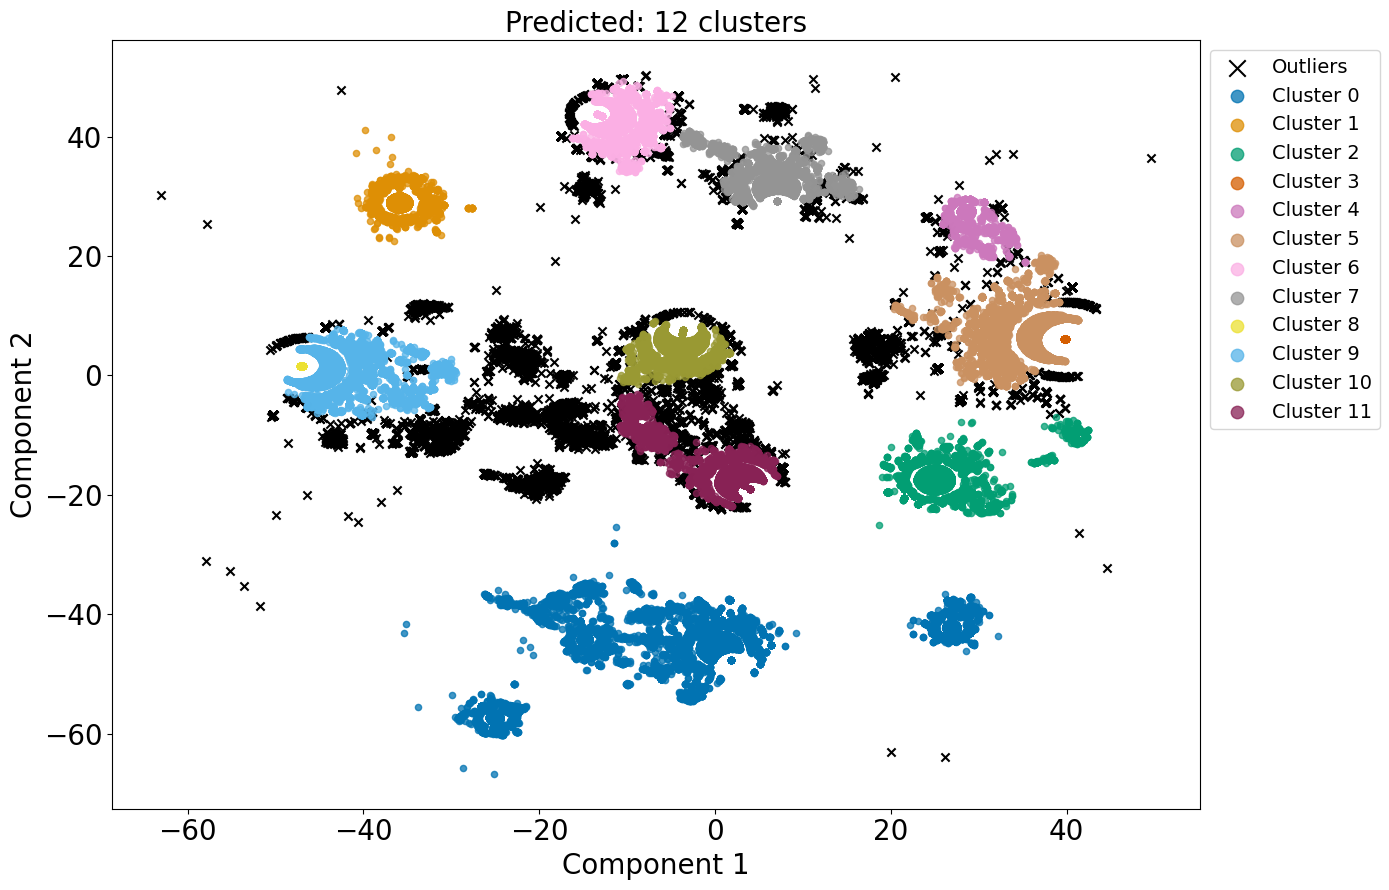

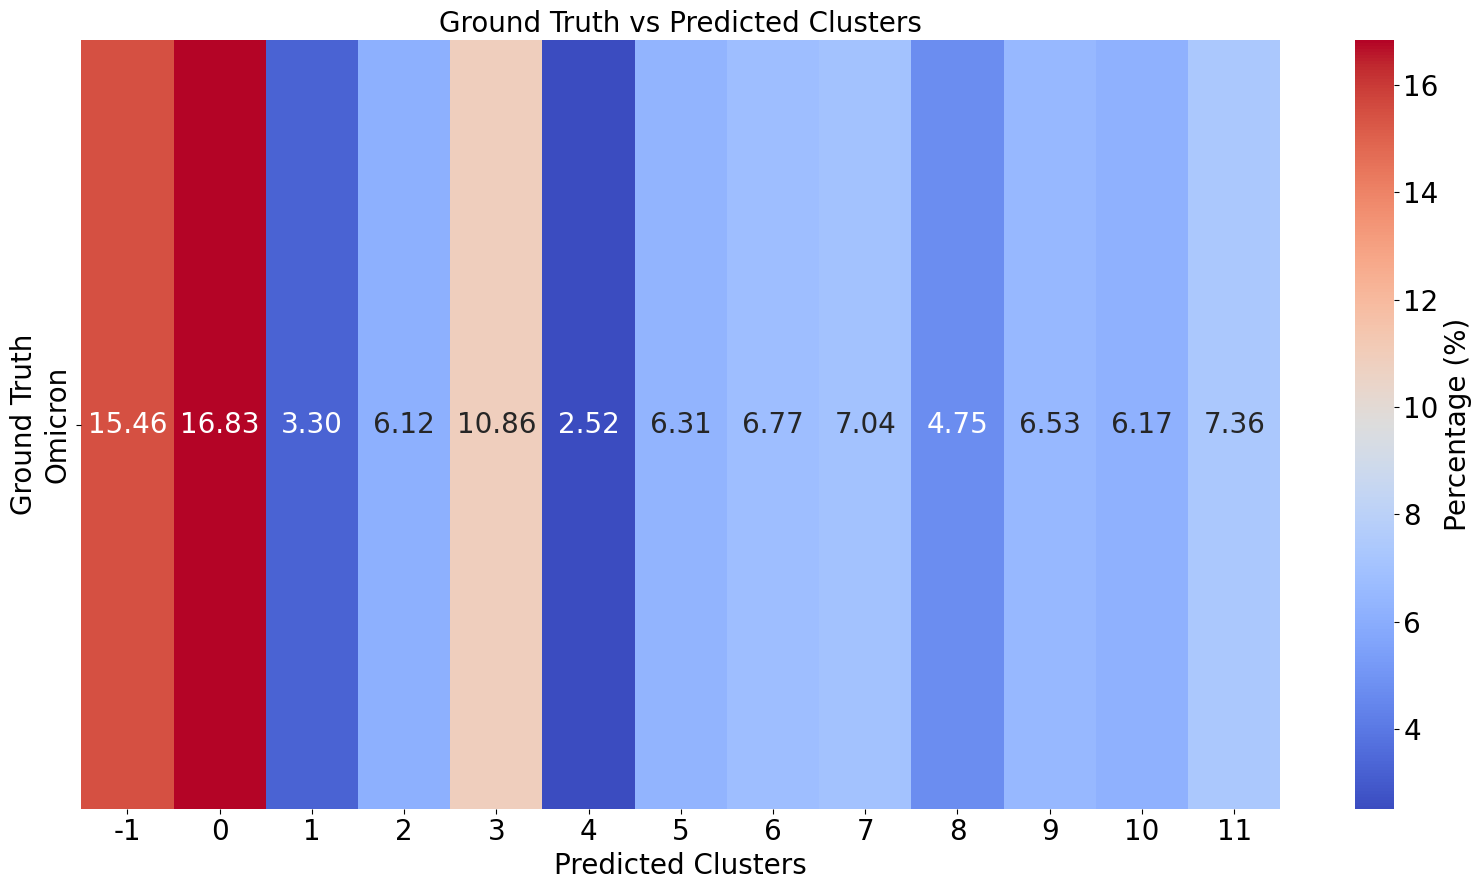

Predicted Clusters,-1,0,1,2,3,4,5,6,7,8,9,10,11
Ground Truth,,,,,,,,,,,,,
Omicron,24740,26932,5281,9787,17375,4029,10090,10830,11264,7597,10448,9865,11778


In [ ]:
min_samples = 250
min_cluster_size = 4000

# Cluster
hdb_labels_o = hdbscan.HDBSCAN(
    min_samples=min_samples,
    min_cluster_size=min_cluster_size, 
    core_dist_n_jobs=-1  # Enable parallel processing
).fit(embedding_matrix_reduced_o).labels_

# Evaluate clustering
silhouette_avg = silhouette_score(embedding_matrix_reduced_o, hdb_labels_o)
ari = adjusted_rand_score(info_df_o["variant"], hdb_labels_o)
print(f"min_sample {min_samples}, min_cluster_size {min_cluster_size}: Silhouette Coefficient: {silhouette_avg:.2f}, Adjusted Rand Index: {ari:.2f}")
save_as = f"../../results/plots/clustering/RBD.O.seed0.tSNE-perp{perplexity}.HDBSCAN-ms{min_samples}_mcs{min_cluster_size}-sc{silhouette_avg:.2f}_ari{ari:.2f}"
plot_hdbscan_predictions(save_as, info_df_o, embedding_matrix_reduced_o, hdb_labels_o, "variant", "tab20")

# Create the truth table
plot_hdbscan_truthtable_heatmap(save_as, info_df_o, hdb_labels_o, "variant")

truth_table = pd.crosstab(info_df_o["variant"], hdb_labels_o, 
                                rownames=['Ground Truth'], 
                                colnames=['Predicted Clusters'])
print(truth_table)

# Cluster info
info_df_o['Cluster'] = hdb_labels_o
result = cluster_pango_lineage(info_df_o, 5)
# result.to_csv('./data/RBD_cluster_lineages-old_ESM-BLSTM.csv', index=False)

clusters = result['Cluster'].unique()
clustered_dataframes = split_dataframe_by_cluster(result)

for cluster in clusters:
    print(f"{clustered_dataframes[cluster]}\n")

cluster_date_collected(save_as, info_df_o, "tab20")

We have some options...